In [17]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

from tqdm import tqdm
from pprint import pprint

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


### Dataset images

You can find dataset images celeba in here: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

Download it, and create a directory called "./img_align_celeba", save all images right there. 

# 1) Load data

In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

## 1.1) Slice dataset in train-val-test

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

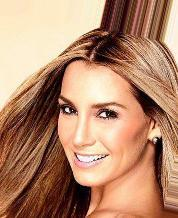

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

## 1.2) Let's preprocessing all images with tf dataset

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [9]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x))
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x))
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x))
)

## 2) Create simple VAE Architecture

In [40]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [41]:
codings_size = 16

inputs = keras.layers.Input(shape=[128, 128, 3])
# Z = keras.layers.Conv2D(16, 4, padding="same", activation="relu")(inputs)
# Z = keras.layers.MaxPool2D(pool_size=2)(Z)

Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
Z = keras.layers.Flatten()(Z)

codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

# ---------

codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
x = keras.layers.Reshape((4, 4, 256))(x)

x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


outputs = keras.layers.Reshape([128, 128, 3])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [42]:
_, _, codings = variational_encoder([inputs])
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))

In [43]:
variational_ae.compile(loss='mse', optimizer="adam")

In [44]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

In [45]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

In [ ]:
for epoch in tqdm(range(30)):
    for X_batch_1 in dataset_train:
        # Fase 0 - Treinar a rede VAE
        
        variational_ae.train_on_batch(X_batch_1[0], X_batch_1[1])
        generated_images = variational_ae(X_batch_1[0])
    plot_multiple_images(generated_images.numpy(), 8)
    plt.show()

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]